# Multi-Factor Batch Evaluation
Define multiple factor sets and evaluate each in one run.
Supports multiple holding windows and outputs VIF + pairwise correlation + rolling betas.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/ubuntu/code/cb_cache')
import cb_cache as cbc


/home/ubuntu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
# Parameters
start_date = 20140102
end_date = 20251224
holding_days_list = [5, 20]
root_path = '/home/ubuntu/scripts/cache_all'

# Optional one-hot controls
use_industry_onehot = True
use_area_onehot = True
use_country_dummy = True
include_intercept = False
dummy_drop_first = False
use_zero_sum_constraints = True

# Define factor sets to evaluate
factor_sets = {
    't1': ['SIZE', 'LIQUIDITY'],
    't2': ['LNCAP', 'MIDCAP', 'LIQUIDITY'],
    't4': ['SIZE', 'LIQUIDITY', 'Volatility'],
    't5': ['SIZE', 'LIQUIDITY', 'Momentum'],
    't6': ['SIZE', 'LIQUIDITY', 'Volatility', 'Momentum'],
}

# Pairwise correlation threshold to report
corr_threshold = 0.7

# Rolling beta window
rolling_window = 60


In [3]:
# Load data with cb_cache
symbols = cbc.get_all_symbols()
cache = cbc.EqCache(symbols, start_date, end_date, root_path=root_path)

dates = cache.daily.dates
close = cache.daily.close

# cache factor matrices
factor_mats = {}
all_factors = sorted({f for fs in factor_sets.values() for f in fs})
for name in all_factors:
    if not hasattr(cache.daily, name):
        raise ValueError(f'factor not found: {name}')
    factor_mats[name] = getattr(cache.daily, name)


# optional control matrices
industry_mat = cache.daily.industry if use_industry_onehot else None
area_mat = cache.daily.area if use_area_onehot else None
country_mat = cache.daily.COUNTRY_CN if use_country_dummy and hasattr(cache.daily, 'COUNTRY_CN') else None


In [4]:
def build_forward_returns(close_arr, holding_days):
    fwd_ret = np.full_like(close_arr, np.nan, dtype=np.float64)
    if holding_days < close_arr.shape[0]:
        fwd_ret[:-holding_days, :] = close_arr[holding_days:, :] / close_arr[:-holding_days, :] - 1.0
    valid_idx = np.arange(close_arr.shape[0] - holding_days)
    dates_eval = dates[valid_idx]
    ret_eval = fwd_ret[valid_idx, :]
    return valid_idx, dates_eval, ret_eval

forward_map = {
    h: build_forward_returns(close, h) for h in holding_days_list
}


<ipython-input-4-335f79030df2>:4: RuntimeWarning: divide by zero encountered in true_divide
  fwd_ret[:-holding_days, :] = close_arr[holding_days:, :] / close_arr[:-holding_days, :] - 1.0
<ipython-input-4-335f79030df2>:4: RuntimeWarning: invalid value encountered in true_divide
  fwd_ret[:-holding_days, :] = close_arr[holding_days:, :] / close_arr[:-holding_days, :] - 1.0


In [5]:
def winsorize_zscore(x, multiplier=5.0):
    mask = np.isfinite(x)
    if mask.sum() < 5:
        return x
    vals = x[mask]
    med = np.nanmedian(vals)
    mad = np.nanmedian(np.abs(vals - med))
    if not np.isfinite(mad) or mad == 0:
        return x
    upper = med + multiplier * mad
    lower = med - multiplier * mad
    clipped = np.clip(vals, lower, upper)
    mean = np.nanmean(clipped)
    std = np.nanstd(clipped)
    if not np.isfinite(std) or std == 0:
        return x
    out = x.copy()
    out[mask] = (clipped - mean) / std
    return out

def compute_vif(X):
    vif = []
    for i in range(X.shape[1]):
        y = X[:, i]
        X_other = np.delete(X, i, axis=1)
        X_other = np.column_stack([np.ones(X_other.shape[0]), X_other])
        beta, *_ = np.linalg.lstsq(X_other, y, rcond=None)
        y_hat = X_other @ beta
        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - y.mean()) ** 2)
        r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
        vif.append(1.0 / (1.0 - r2) if np.isfinite(r2) and r2 < 1.0 else np.nan)
    return np.array(vif)

def pairwise_corr(X, names, threshold=0.7):
    df = pd.DataFrame(X, columns=names)
    corr = df.corr()
    rows = []
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            val = corr.iloc[i, j]
            if np.isfinite(val) and abs(val) >= threshold:
                rows.append({
                    'factor_a': names[i],
                    'factor_b': names[j],
                    'corr': val,
                })
    if not rows:
        return pd.DataFrame(columns=['factor_a', 'factor_b', 'corr'])
    out = pd.DataFrame(rows)
    out = out.sort_values('corr', key=lambda s: s.abs(), ascending=False)
    return out


def build_onehot(vec, prefix, drop_first=True):
    mask = np.isfinite(vec)
    if mask.sum() == 0:
        return None, []
    cats = np.unique(vec[mask].astype(int))
    if cats.size <= 1:
        return None, []
    if drop_first:
        cats = cats[1:]
    out = []
    names = []
    for c in cats:
        col = (vec == c).astype(float)
        col[~mask] = np.nan
        out.append(col)
        names.append(f"{prefix}_{c}")
    return np.column_stack(out), names


def solve_constrained_ols(X, y, constraint_groups):
    if not constraint_groups:
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        return beta
    n_params = X.shape[1]
    C = np.zeros((len(constraint_groups), n_params))
    for i, idxs in enumerate(constraint_groups):
        C[i, idxs] = 1.0
    XtX = X.T @ X
    Xty = X.T @ y
    top = np.hstack([XtX, C.T])
    bottom = np.hstack([C, np.zeros((C.shape[0], C.shape[0]))])
    KKT = np.vstack([top, bottom])
    rhs = np.concatenate([Xty, np.zeros(C.shape[0])])
    sol, *_ = np.linalg.lstsq(KKT, rhs, rcond=None)
    return sol[:n_params]


In [6]:
results = []
coef_rows = []
vif_rows = []
corr_rows = []

for holding_days in holding_days_list:
    valid_idx, dates_eval, ret_eval = forward_map[holding_days]

    for set_name, factors in factor_sets.items():
        r2_list = []
        coef_list = []

        for di, d in enumerate(dates_eval):
            y = ret_eval[di]
            X_cols = []
            for name in factors:
                x = factor_mats[name][valid_idx[di]]
                x = winsorize_zscore(x)
                X_cols.append(x)
            control_cols = []
            control_names = []
            control_groups = []
            if use_industry_onehot and industry_mat is not None:
                vec = industry_mat[valid_idx[di]]
                mat, names = build_onehot(vec, 'IND', drop_first=dummy_drop_first)
                if mat is not None:
                    control_cols.append(mat)
                    control_names.extend(names)
                    control_groups.append('IND')
            if use_area_onehot and area_mat is not None:
                vec = area_mat[valid_idx[di]]
                mat, names = build_onehot(vec, 'AREA', drop_first=dummy_drop_first)
                if mat is not None:
                    control_cols.append(mat)
                    control_names.extend(names)
                    control_groups.append('AREA')
            if use_country_dummy and country_mat is not None:
                vec = country_mat[valid_idx[di]]
                mat, names = build_onehot(vec, 'CTY', drop_first=dummy_drop_first)
                if mat is not None:
                    control_cols.append(mat)
                    control_names.extend(names)
                    control_groups.append('CTY')
            constraint_groups = []
            if use_zero_sum_constraints:
                start = len(X_cols)
                for mat, group in zip(control_cols, control_groups):
                    if mat is None:
                        continue
                    end = start + mat.shape[1]
                    if group != 'CTY':
                        constraint_groups.append(list(range(start, end)))
                    start = end
            X = np.column_stack(X_cols + control_cols)
            factor_names = factors + control_names
            mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
            if mask.sum() < (len(factors) + 5):
                continue
            X_m = X[mask]
            y_m = y[mask]
            if include_intercept:
                X_m = np.column_stack([np.ones(X_m.shape[0]), X_m])
            offset = 1 if include_intercept else 0
            beta = solve_constrained_ols(
                X_m,
                y_m,
                [[i + offset for i in grp] for grp in constraint_groups] if use_zero_sum_constraints else [],
            )
            y_hat = X_m @ beta
            ss_res = np.sum((y_m - y_hat) ** 2)
            ss_tot = np.sum((y_m - y_m.mean()) ** 2)
            r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
            r2_list.append(r2)
            for i, name in enumerate(factor_names):
                coef_list.append({
                    'holding_days': holding_days,
                    'set': set_name,
                    'date': int(d),
                    'factor': name,
                    'coef': beta[i + offset],
                })

        r2_series = pd.Series(r2_list)
        results.append({
            'holding_days': holding_days,
            'set': set_name,
            'factors': ','.join(factors),
            'r2_mean': r2_series.mean(),
            'r2_median': r2_series.median(),
            'r2_std': r2_series.std(),
            'obs': r2_series.size,
        })
        coef_rows.extend(coef_list)

        # VIF and pairwise corr on latest valid date
        for di in range(len(dates_eval) - 1, -1, -1):
            X_cols = []
            for name in factors:
                x = factor_mats[name][valid_idx[di]]
                x = winsorize_zscore(x)
                X_cols.append(x)
            control_cols = []
            control_names = []
            control_groups = []
            if use_industry_onehot and industry_mat is not None:
                vec = industry_mat[valid_idx[di]]
                mat, names = build_onehot(vec, 'IND', drop_first=dummy_drop_first)
                if mat is not None:
                    control_cols.append(mat)
                    control_names.extend(names)
                    control_groups.append('IND')
            if use_area_onehot and area_mat is not None:
                vec = area_mat[valid_idx[di]]
                mat, names = build_onehot(vec, 'AREA', drop_first=dummy_drop_first)
                if mat is not None:
                    control_cols.append(mat)
                    control_names.extend(names)
                    control_groups.append('AREA')
            if use_country_dummy and country_mat is not None:
                vec = country_mat[valid_idx[di]]
                mat, names = build_onehot(vec, 'CTY', drop_first=dummy_drop_first)
                if mat is not None:
                    control_cols.append(mat)
                    control_names.extend(names)
                    control_groups.append('CTY')
            constraint_groups = []
            if use_zero_sum_constraints:
                start = len(X_cols)
                for mat, group in zip(control_cols, control_groups):
                    if mat is None:
                        continue
                    end = start + mat.shape[1]
                    if group != 'CTY':
                        constraint_groups.append(list(range(start, end)))
                    start = end
            X = np.column_stack(X_cols + control_cols)
            factor_names = factors + control_names
            mask = np.all(np.isfinite(X), axis=1)
            if mask.sum() < (len(factors) + 5):
                continue
            X_m = X[mask]
            vif_vals = compute_vif(X_m)
            for name, vif in zip(factor_names, vif_vals):
                vif_rows.append({
                    'holding_days': holding_days,
                    'set': set_name,
                    'factor': name,
                    'vif': vif,
                    'date': int(dates_eval[di]),
                })

            corr_df = pairwise_corr(X_m, factor_names, threshold=corr_threshold)
            if not corr_df.empty:
                corr_df.insert(0, 'holding_days', holding_days)
                corr_df.insert(1, 'set', set_name)
                corr_df.insert(2, 'date', int(dates_eval[di]))
                corr_rows.append(corr_df)
            break

results_df = pd.DataFrame(results)
coef_df = pd.DataFrame(coef_rows)
vif_df = pd.DataFrame(vif_rows)
corr_df = pd.concat(corr_rows, ignore_index=True) if corr_rows else pd.DataFrame()

results_df


,holding_days,set,factors,r2_mean,r2_median,r2_std,obs
0,5,t1,"SIZE,LIQUIDITY",0.028523,0.016754,0.034776,2642
1,5,t2,"LNCAP,MIDCAP,LIQUIDITY",0.047756,0.033237,0.046129,2642
2,5,t4,"SIZE,LIQUIDITY,Volatility",0.071136,0.049266,0.077513,2497
3,5,t5,"SIZE,LIQUIDITY,Momentum",0.031714,0.019928,0.036343,2642
4,20,t1,"SIZE,LIQUIDITY",0.031632,0.020406,0.034689,2630
5,20,t2,"LNCAP,MIDCAP,LIQUIDITY",0.058636,0.043327,0.053756,2630
6,20,t4,"SIZE,LIQUIDITY,Volatility",0.077471,0.049187,0.090642,2482
7,20,t5,"SIZE,LIQUIDITY,Momentum",0.035229,0.023583,0.040204,2630


In [7]:
# Coefficient summary per set
coef_summary = coef_df.groupby(['holding_days', 'set', 'factor'])['coef'].agg(['mean', 'std', 'count'])
coef_summary['t_stat'] = coef_summary['mean'] / (coef_summary['std'] / np.sqrt(coef_summary['count']))
coef_summary


mean       std  count     t_stat
holding_days set factor                                          
5            t1  LIQUIDITY  -0.002361  0.010391   2642 -11.678695
                 SIZE        0.001525  0.006968   2642  11.246763
             t2  LIQUIDITY  -0.005423  0.011345   2642 -24.572014
                 LNCAP      -0.002398  0.012157   2642 -10.138439
                 MIDCAP      0.004127  0.010125   2642  20.952991
             t4  LIQUIDITY  -0.006157  0.020092   2497 -15.312157
                 SIZE       -0.000070  0.012959   2497  -0.270028
                 Volatility  0.003439  0.039429   2497   4.358076
             t5  LIQUIDITY  -0.002385  0.010268   2642 -11.940963
                 Momentum    0.000712  0.114040   2642   0.320999
                 SIZE        0.001487  0.006774   2642  11.282781
20           t1  LIQUIDITY  -0.007171  0.021047   2630 -17.472966
                 SIZE        0.003035  0.013173   2630  11.815967
             t2  LIQUIDITY  -0.015753  0.025092   2630 -32.195148
                 LNCAP      -0.007736  0.025969   2630 -15.277157
                 MIDCAP      0.010789  0.021537   2630  25.691290
             t4  LIQUIDITY  -0.016135  0.037887   2482 -21.217177
                 SIZE        0.001994  0.027395   2482   3.626457
                 Volatility  0.010626  0.087410   2482   6.056470
             t5  LIQUIDITY  -0.007215  0.020756   2630 -17.827794
                 Momentum   -0.000125  0.243955   2630  -0.026180
                 SIZE        0.003014  0.012939   2630  11.946390

In [8]:
coef_summary.loc[20, 't6']

KeyError: 't6'

In [ ]:
# Rolling beta (per set/factor/holding_days)
coef_df_sorted = coef_df.sort_values(['holding_days', 'set', 'factor', 'date'])
rolling_rows = []
for (holding_days, set_name, factor), grp in coef_df_sorted.groupby(['holding_days', 'set', 'factor']):
    vals = grp['coef'].rolling(rolling_window, min_periods=20).mean()
    tmp = grp[['date']].copy()
    tmp['holding_days'] = holding_days
    tmp['set'] = set_name
    tmp['factor'] = factor
    tmp['beta_roll'] = vals.values
    rolling_rows.append(tmp)

rolling_df = pd.concat(rolling_rows, ignore_index=True)
rolling_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_beta_rolling.csv', index=False)
rolling_df.head()


,date,holding_days,set,factor,beta_roll
0,20140102,5,t1,LIQUIDITY,NaN
1,20150113,5,t1,LIQUIDITY,NaN
2,20150114,5,t1,LIQUIDITY,NaN
3,20150115,5,t1,LIQUIDITY,NaN
4,20150116,5,t1,LIQUIDITY,NaN


In [ ]:
# Beta stability metrics
stability_rows = []
for (holding_days, set_name, factor), grp in rolling_df.groupby(['holding_days', 'set', 'factor']):
    vals = grp['beta_roll'].dropna()
    if vals.empty:
        continue
    stability_rows.append({
        'holding_days': holding_days,
        'set': set_name,
        'factor': factor,
        'beta_mean': vals.mean(),
        'beta_std': vals.std(),
        'beta_cv': vals.std() / abs(vals.mean()) if vals.mean() != 0 else np.nan,
        'beta_sign_flip_rate': (np.sign(vals).diff() != 0).mean(),
        'count': vals.size,
    })

stability_df = pd.DataFrame(stability_rows).sort_values(['holding_days', 'set', 'beta_cv'])
stability_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_beta_stability.csv', index=False)
stability_df


,holding_days,set,factor,beta_mean,beta_std,beta_cv,beta_sign_flip_rate,count
0,5,t1,LIQUIDITY,-0.002365,0.003027,1.280026,0.020587,2623
1,5,t1,SIZE,0.001527,0.002933,1.921007,0.017537,2623
2,5,t2,LIQUIDITY,-0.005463,0.005846,1.070268,0.008006,2623
4,5,t2,MIDCAP,0.004145,0.005312,1.281521,0.019443,2623
3,5,t2,LNCAP,-0.002453,0.004037,1.646161,0.014106,2623
...,...,...,...,...,...,...,...,...
76,20,t8,Monthly_share_turnover,-0.004394,0.050490,11.489836,0.011924,2432
69,20,t8,Annualized_traded_value_ratio,-0.003533,0.041220,11.666477,0.008635,2432
75,20,t8,MIDCAP,0.002168,0.031248,14.411513,0.013980,2432
68,20,t8,Annual_share_turnover,-0.002416,0.043572,18.034948,0.011924,2432


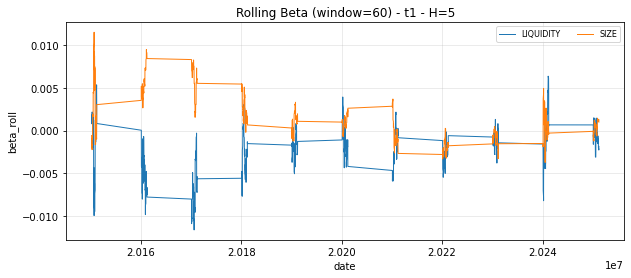

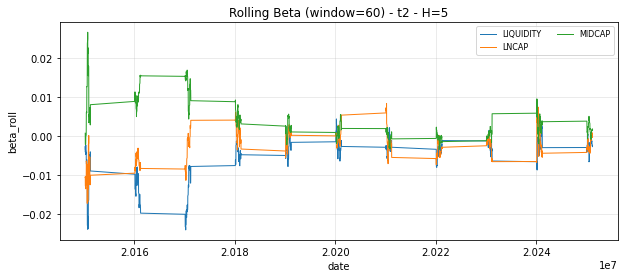

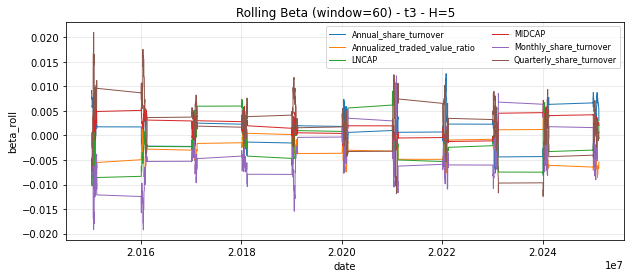

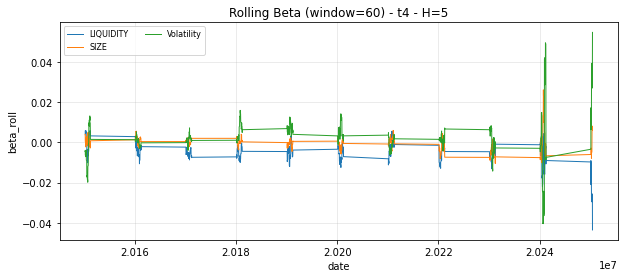

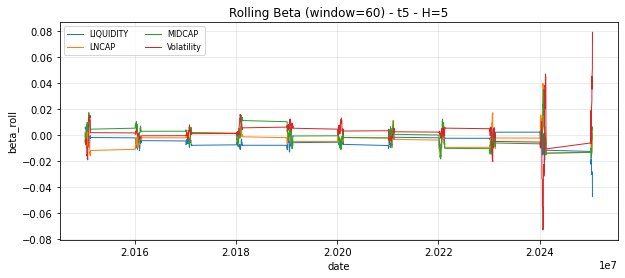

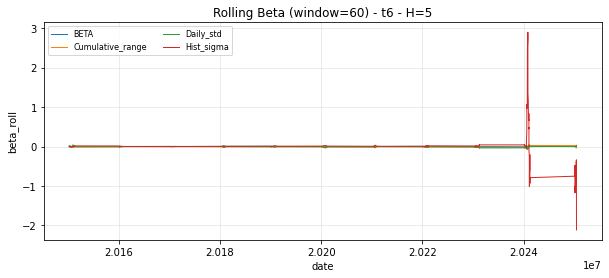

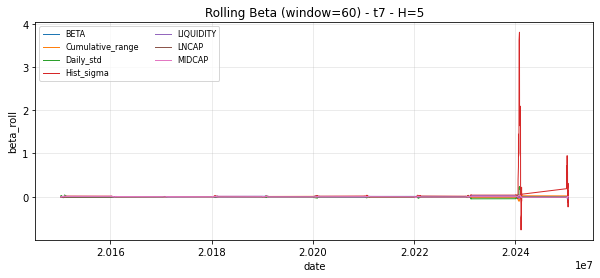

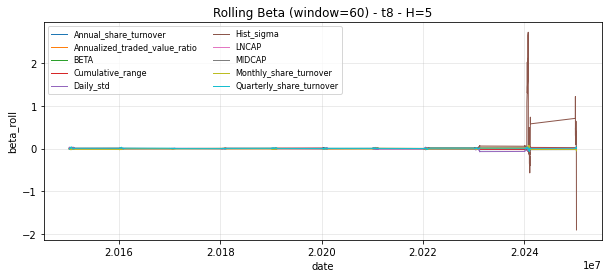

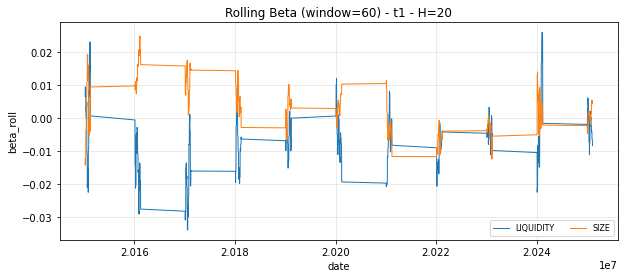

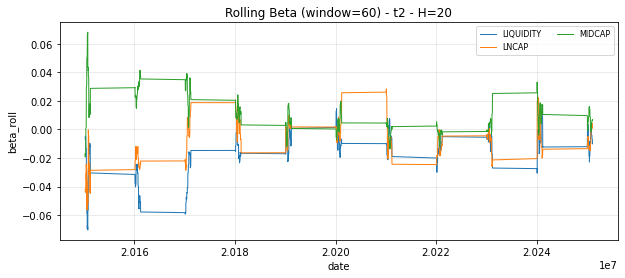

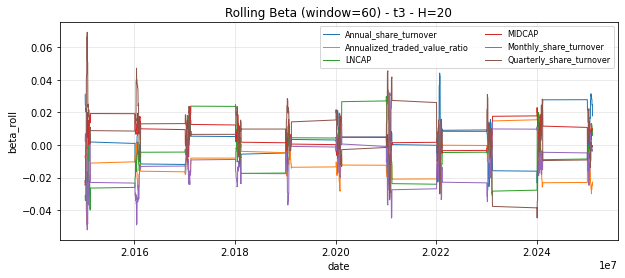

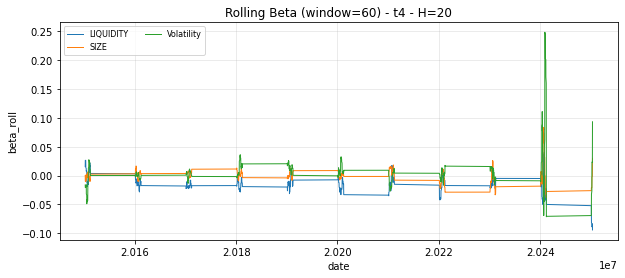

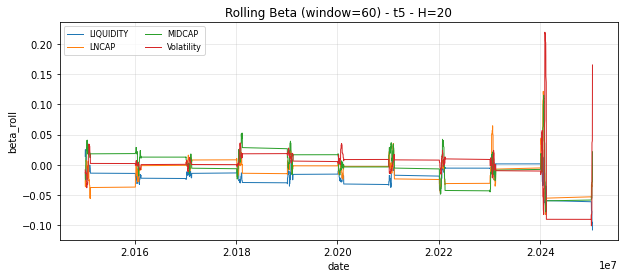

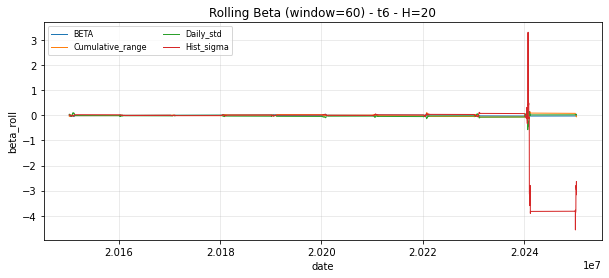

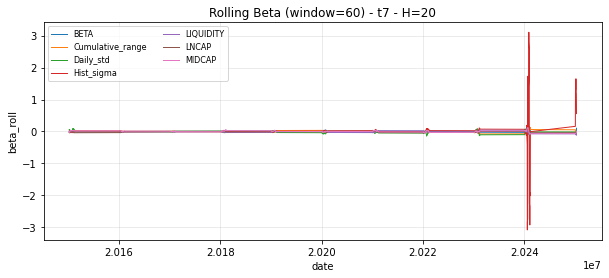

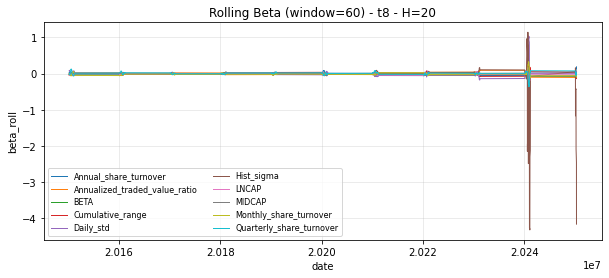

In [ ]:
# Rolling beta time series plots
for holding_days in holding_days_list:
    df_h = rolling_df[rolling_df['holding_days'] == holding_days]
    for set_name, grp in df_h.groupby('set'):
        fig, ax = plt.subplots(figsize=(10, 4))
        for factor, g in grp.groupby('factor'):
            ax.plot(g['date'], g['beta_roll'], label=factor, linewidth=1)
        ax.set_title(f'Rolling Beta (window={rolling_window}) - {set_name} - H={holding_days}')
        ax.set_xlabel('date')
        ax.set_ylabel('beta_roll')
        ax.legend(ncol=2, fontsize=8)
        ax.grid(alpha=0.3)
        plt.show()


In [ ]:
# Rolling beta prediction evaluation
pred_rows = []
pred_beta_rows = []

for holding_days in holding_days_list:
    valid_idx, dates_eval, ret_eval = forward_map[holding_days]
    df_h = rolling_df[rolling_df['holding_days'] == holding_days]

    for set_name, factors in factor_sets.items():
        beta_map = {}
        for factor in factors:
            g = df_h[(df_h['set'] == set_name) & (df_h['factor'] == factor)]
            beta_map[factor] = g.set_index('date')['beta_roll']

        for di, d in enumerate(dates_eval):
            d_int = int(d)
            betas = []
            X_cols = []
            for factor in factors:
                if d_int not in beta_map[factor]:
                    betas = None
                    break
                beta = beta_map[factor].loc[d_int]
                if not np.isfinite(beta):
                    betas = None
                    break
                x = factor_mats[factor][valid_idx[di]]
                x = winsorize_zscore(x)
                betas.append(beta)
                X_cols.append(x)
            if betas is None:
                continue
            for factor, beta in zip(factors, betas):
                pred_beta_rows.append({
                    'holding_days': holding_days,
                    'set': set_name,
                    'date': d_int,
                    'factor': factor,
                    'beta': float(beta),
                })

            X = np.column_stack(X_cols)
            mask = np.all(np.isfinite(X), axis=1) & np.isfinite(ret_eval[di])
            if mask.sum() < (len(factors) + 5):
                continue
            X_m = X[mask]
            y_m = ret_eval[di][mask]
            pred = X_m @ np.array(betas)

            ic = pd.Series(pred).corr(pd.Series(y_m))
            ric = pd.Series(pred).rank(pct=True).corr(pd.Series(y_m).rank(pct=True))

            pred_rows.append({
                'holding_days': holding_days,
                'set': set_name,
                'date': d_int,
                'ic': ic,
                'rank_ic': ric,
            })

pred_df = pd.DataFrame(pred_rows)
pred_summary = pred_df.groupby(['holding_days', 'set'])[['ic', 'rank_ic']].agg(['mean', 'std'])
pred_summary.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_pred_ic_summary.csv')
pred_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_pred_ic.csv', index=False)
pred_beta_df = pd.DataFrame(pred_beta_rows).drop_duplicates()
pred_beta_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_pred_betas.csv', index=False)
pred_summary


ic             rank_ic          
                      mean       std      mean       std
holding_days set                                        
5            t1   0.039495  0.122702  0.047173  0.149141
             t2   0.078841  0.129129  0.069612  0.138658
             t3   0.058168  0.121500  0.076602  0.141410
             t4   0.074223  0.165183  0.069360  0.164683
             t5   0.088494  0.170832  0.083717  0.173054
             t6   0.088124  0.186760  0.080623  0.185306
             t7   0.110238  0.185214  0.101717  0.180672
             t8   0.099227  0.174664  0.099231  0.175947
20           t1   0.059157  0.122890  0.076785  0.154248
             t2   0.109138  0.136961  0.109651  0.148760
             t3   0.097035  0.136577  0.116488  0.153125
             t4   0.102439  0.165597  0.102295  0.168691
             t5   0.131128  0.165401  0.136860  0.172025
             t6   0.117120  0.174942  0.118396  0.180398
             t7   0.155804  0.167027  0.157414  0.171946
             t8   0.162671  0.168147  0.165774  0.174519

In [ ]:
# Save outputs
results_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_r2_summary.csv', index=False)
coef_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_coef.csv', index=False)
coef_summary.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_coef_summary.csv')
vif_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_vif.csv', index=False)
corr_df.to_csv('/home/ubuntu/scripts/cache_all/batch_factor_pairwise_corr.csv', index=False)
'/home/ubuntu/scripts/cache_all/batch_factor_r2_summary.csv'


'/home/ubuntu/scripts/cache_all/batch_factor_r2_summary.csv'